In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
# !pip install xgboost
import xgboost
from xgboost import XGBClassifier
# !pip install lightgbm
import lightgbm as lgb
# !pip install catboost
from catboost import CatBoostClassifier, Pool

In [2]:
# データ準備
df = sns.load_dataset('titanic')
df.dropna(inplace=True)
# X, yを作成
X = df.drop(['survived', 'alive'], axis=1)
y = df['survived']
# ラベルエンコーディング
oe = OrdinalEncoder()
oe.set_output(transform='pandas')
cat_cols = X.select_dtypes(exclude=np.number).columns.to_list()
X[cat_cols] = oe.fit_transform(X[cat_cols])
# hold-out
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## XGBoost

In [3]:
xgb = XGBClassifier(learning_rate=0.01,
              eval_metric='auc',
              early_stopping_rounds=10,
              importance_type='total_gain',
              random_state=0)
# 学習
xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

[0]	validation_0-auc:0.89904
[1]	validation_0-auc:0.89663
[2]	validation_0-auc:0.89663
[3]	validation_0-auc:0.89663
[4]	validation_0-auc:0.89663
[5]	validation_0-auc:0.89663
[6]	validation_0-auc:0.89103
[7]	validation_0-auc:0.89103
[8]	validation_0-auc:0.88942
[9]	validation_0-auc:0.89103


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None,
              importance_type='total_gain', interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=0, ...)

In [4]:
# 予測と評価
y_pred_xgb = xgb.predict_proba(X_test)
print(f"xgboost AUC: {roc_auc_score(y_test, y_pred_xgb[:, 1])}")

xgboost AUC: 0.8990384615384616


In [5]:
# 特徴量の重要度
xgb.feature_importances_

array([0.        , 0.        , 0.10952041, 0.        , 0.        ,
       0.22573484, 0.        , 0.        , 0.        , 0.59854376,
       0.05928717, 0.        , 0.00691384], dtype=float32)

<AxesSubplot:>

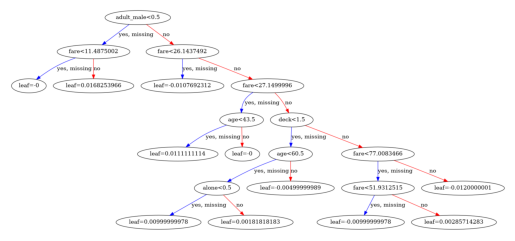

In [6]:
# 弱学習器の木構造を描画
xgboost.plot_tree(xgb, num_trees=0)

### LightGBM

In [7]:
lgbmc = lgb.LGBMClassifier(boosting_type='goss', max_depth=5, random_state=0)
# early stoppingに使用する検証データ
eval_set = [(X_test, y_test)]
# イテレーション時に実施(callback)する関数
callbacks = []
callbacks.append(lgb.early_stopping(stopping_rounds=10))
callbacks.append(lgb.log_evaluation())
# 学習
lgbmc.fit(X_train, y_train, eval_set=eval_set, callbacks=callbacks)

[1]	valid_0's binary_logloss: 0.56902
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.536293
[3]	valid_0's binary_logloss: 0.50876
[4]	valid_0's binary_logloss: 0.485108
[5]	valid_0's binary_logloss: 0.464864
[6]	valid_0's binary_logloss: 0.447251
[7]	valid_0's binary_logloss: 0.433086
[8]	valid_0's binary_logloss: 0.41859
[9]	valid_0's binary_logloss: 0.408127
[10]	valid_0's binary_logloss: 0.400311
[11]	valid_0's binary_logloss: 0.400311
[12]	valid_0's binary_logloss: 0.400311
[13]	valid_0's binary_logloss: 0.400311
[14]	valid_0's binary_logloss: 0.400311
[15]	valid_0's binary_logloss: 0.400311
[16]	valid_0's binary_logloss: 0.400311
[17]	valid_0's binary_logloss: 0.400311
[18]	valid_0's binary_logloss: 0.400311
[19]	valid_0's binary_logloss: 0.400311
[20]	valid_0's binary_logloss: 0.400311
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.400311


LGBMClassifier(boosting_type='goss', max_depth=5, random_state=0)

In [8]:
# 予測と評価
y_pred_lgbmc = lgbmc.predict_proba(X_test)
print(f"light gbm AUC: {roc_auc_score(y_test, y_pred_lgbmc[:, 1])}")

light gbm AUC: 0.9383012820512822


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

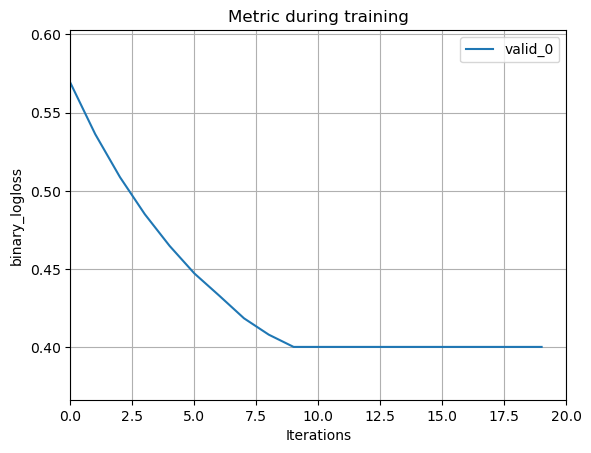

In [9]:
# 学習曲線
lgb.plot_metric(lgbmc)

<AxesSubplot:>

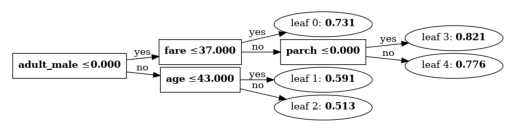

In [10]:
# 弱学習器の木構造を描画
lgb.plot_tree(lgbmc, tree_index=0)

### CatBoost

In [11]:
# データ準備 (ラベルエンコーディングをしないバージョン)
df = sns.load_dataset('titanic')
df.dropna(inplace=True)
# X, yを作成
X = df.loc[:, (df.columns!='survived') & (df.columns!='alive')]
y = df['survived']
# カテゴリカル変数のカラム名のリスト
cat_cols = X.select_dtypes(exclude=np.number).columns.to_list()
# CatBoostはカテゴリカル編数の事前エンコーディングは不要
# oe = OrdinalEncoder()
# oe.set_output(transform='pandas')
# X = oe.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [12]:
cbc = CatBoostClassifier(iterations=1000, learning_rate=0.01, cat_features=cat_cols)
eval_set = [(X_test, y_test)]
# 学習
cbc.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=10, verbose=True)

0:	learn: 0.6885366	test: 0.6868442	best: 0.6868442 (0)	total: 136ms	remaining: 2m 16s
1:	learn: 0.6814490	test: 0.6793775	best: 0.6793775 (1)	total: 176ms	remaining: 1m 27s
2:	learn: 0.6760508	test: 0.6726860	best: 0.6726860 (2)	total: 198ms	remaining: 1m 5s
3:	learn: 0.6712676	test: 0.6671826	best: 0.6671826 (3)	total: 218ms	remaining: 54.2s
4:	learn: 0.6653107	test: 0.6593995	best: 0.6593995 (4)	total: 238ms	remaining: 47.3s
5:	learn: 0.6598695	test: 0.6518437	best: 0.6518437 (5)	total: 257ms	remaining: 42.6s
6:	learn: 0.6558456	test: 0.6467404	best: 0.6467404 (6)	total: 276ms	remaining: 39.1s
7:	learn: 0.6515199	test: 0.6413944	best: 0.6413944 (7)	total: 295ms	remaining: 36.6s
8:	learn: 0.6471426	test: 0.6356173	best: 0.6356173 (8)	total: 321ms	remaining: 35.3s
9:	learn: 0.6431772	test: 0.6310513	best: 0.6310513 (9)	total: 344ms	remaining: 34s
10:	learn: 0.6392733	test: 0.6260433	best: 0.6260433 (10)	total: 359ms	remaining: 32.3s
11:	learn: 0.6349835	test: 0.6211657	best: 0.6211657

In [13]:
# 予測と評価
y_pred_cbc = cbc.predict_proba(X_test)
print(f"catboost AUC: {roc_auc_score(y_test, y_pred_cbc[:, 1])}")

catboost AUC: 0.8942307692307693


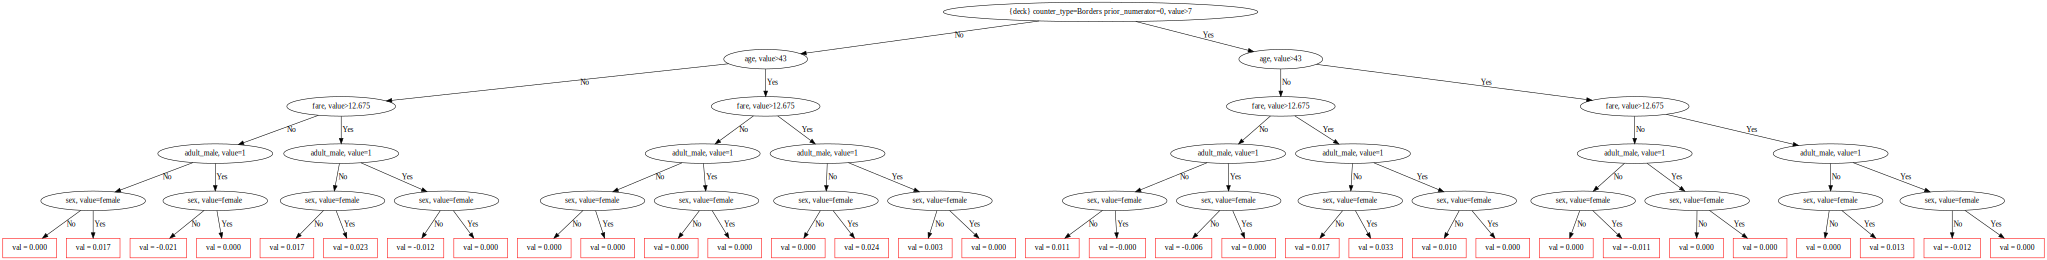

In [14]:
# 弱学習器の描画
# symmetric treeになっていることが確認できる
pool = Pool(X_train, y_train, cat_features=cat_cols)
cbc.plot_tree(tree_idx=1, pool=pool)